<a href="https://colab.research.google.com/github/s2cretjuju/first-repository/blob/master/ds6/%5B%EB%A9%94%EC%9D%B8_%ED%80%98%EC%8A%A4%ED%8A%B8(4)%5D_20251107_%EC%8B%A0%EC%9A%A9_%EC%B9%B4%EB%93%9C_%EC%82%AC%EA%B8%B0_%ED%83%90%EC%A7%80_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Credit Card Fraud Detection**

신용카드 사기 검출을 분류하여 고객이 구매하지 않은 상품에 대해 요금이 청구되지 않도록 하자!

* 예측할 값(y): Class (0: 비사기 거래, 1: 사기 거래)
* 모델 평가 지표: f1-score

#**1. 데이터 준비**

In [127]:
!pip uninstall -y xgboost lightgbm

Found existing installation: xgboost 1.5.0
Uninstalling xgboost-1.5.0:
  Successfully uninstalled xgboost-1.5.0
Found existing installation: lightgbm 3.3.2
Uninstalling lightgbm-3.3.2:
  Successfully uninstalled lightgbm-3.3.2


In [128]:
!pip install xgboost==1.5.0 lightgbm==3.3.2

  Using cached xgboost-1.5.0-py3-none-manylinux2014_x86_64.whl.metadata (1.7 kB)
  Using cached lightgbm-3.3.2-py3-none-manylinux1_x86_64.whl.metadata (15 kB)
Using cached xgboost-1.5.0-py3-none-manylinux2014_x86_64.whl (173.5 MB)
Using cached lightgbm-3.3.2-py3-none-manylinux1_x86_64.whl (2.0 MB)


In [129]:
!pip install hyperopt

In [130]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb

# 훈련 데이터와 테스트 데이터는 미리 준비되어 있습니다.

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

#**2. 데이터 호출 및 확인**

In [132]:
train_df.head(3)

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [133]:
# 데이터 정보 확인
print("--- Train Data Info ---")
print(train_df.info())
print("\n--- Test Data Info ---")
print(test_df.info())
print("\n--- Class Distribution ---")
print(train_df['Class'].value_counts(normalize = True))

--- Train Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null 

전체 컬럼에 대해 결측치 없고, 데이터 타입은 모두 숫자형

0(비사기 거래)의 값 비율: 약 99.8%, 1(사기 거래)의 값 비율: 약 0.2%

#**3. 데이터 일차 가공 및 모델 학습/예측/평가**

In [134]:
# 1. 불필요한 컬럼 (Time, id) 삭제 및 특징/타겟 분리
# X: 특징 (Frature), y: 타겟 (에측할 Class)
# Time, id, Class 컬럼을 제외한 나머지를 X로 지정
X = train_df.drop(['Time', 'id', 'Class'], axis = 1)
y = train_df['Class']
X_test_final = test_df.drop(['Time', 'id'], axis = 1)

print("✅ 'TIme', 'id' 컬럼 삭제 및 특징/타겟 분리 완료.")

✅ 'TIme', 'id' 컬럼 삭제 및 특징/타겟 분리 완료.


In [135]:
# 2. scale_pos_weight 계산
# 가중치 = (비사기 거래 수) / (사기 거래 수)
non_fraud_count = y.value_counts()[0] # 비사기 (Class 0)
fraud_count = y.value_counts()[1] # 사기 (Class 1)
scale_pos_weight_value = non_fraud_count / fraud_count

print(f"\n--- 데이터 불균형 비율 ---")
print(f"비사기 거래 수 (Class 0): {fraud_count}")
print(f"사기 거래 수 (Class 1): {non_fraud_count}")
print(f"계산된 scale_pos_weight: {scale_pos_weight_value:.4f}")



--- 데이터 불균형 비율 ---
비사기 거래 수 (Class 0): 360
사기 거래 수 (Class 1): 170523
계산된 scale_pos_weight: 473.6750


In [136]:
# 3.학습용과 테스트용 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.3, random_state = 42, stratify = y)

print(f"\n✅ 훈련/검증 데이터 분리 완료.")
print(f"훈련 검증 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}")


✅ 훈련/검증 데이터 분리 완료.
훈련 검증 크기: (119618, 29), 검증 데이터 크기: (51265, 29)


##**A. 로지스틱 회귀 분석**

In [137]:
# 로지스틱 회귀로 예측 성능 평가
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

print("--- 로지스틱 회귀 모델 성능 평가 시작 ---")

# 1. 로지스틱 회귀 모델 정의 및 학습
# max_iter = 1000은 모델이 충분히 수렴하도록 반복 횟수를 늘려주는 설정
lr_clf = LogisticRegression(max_iter = 1000, random_state = 42)
lr_clf.fit(X_train, y_train)

# 2. 검증 데이터(X_val)에 대한 예측 수행
lr_pred = lr_clf.predict(X_val)
lr_pred_proba = lr_clf.predict_proba(X_val)[:, 1]

# 3. 모델 평가 수행
f1 = f1_score(y_val, lr_pred)
# 보너스 지표: 정밀도, 재현율, AUC (사기 검출에서 매우 중요)
precision = precision_score(y_val, lr_pred)
recall = recall_score(y_val, lr_pred)
auc = roc_auc_score(y_val, lr_pred_proba)

print(f"\n✅ 로지스틱 회귀 성능 (테스트 데이터 기준, 임계값 0.5)")
print(f"F1-Score: {f1:.4f} (목표 지표)")
print(f"Precision (정밀도): {precision:.4f}")
print(f"Recall (재현율): {recall:.4f}")
print(f"ROC AUC: {auc: .4f}")
print("\nConfusion Matrix (혼동 행렬):")
print(confusion_matrix(y_val, lr_pred))

--- 로지스틱 회귀 모델 성능 평가 시작 ---

✅ 로지스틱 회귀 성능 (테스트 데이터 기준, 임계값 0.5)
F1-Score: 0.7225 (목표 지표)
Precision (정밀도): 0.8313
Recall (재현율): 0.6389
ROC AUC:  0.9812

Confusion Matrix (혼동 행렬):
[[51143    14]
 [   39    69]]


**1. 주요 평가 지표**
* ROC AUC (0.9812): 모델의 전반적인 분류 능력을 평가 하는 것으로, 1에 가까울수록 좋은 모델.현재 0.9812로 1과 매우 가깝기 때문에 매우 우수하다고 볼 수 있음

* F1-Score (0.7225): 정밀도와 재현율의 조화 평균을 나타내며, 사기 검출의 목표 지표로 양호한 편

* Precission (정밀도, 0.8313): 모델이 사기라고 예측했을 때, 실제로 사기일 확률이며, 약 83%로 높은 수준 (오탐지율 낮음)

* Recall (재현율, 0.6389): 실제 사기 거래 중 모델이 찾아낸 비율로, 가장 낮음. 실제 사기 거래 10건 중 6-7건만 잡아냈다는 의미 (오탐지율 높음)

---

**2. 혼동 행렬 (Confusion Matrix)**
* TP (진짜 사기): 69건 - 사기를 사기로 예측
* TN (진짜 비사기): 51,143건 - 비사기를 비사기로 예측
* FP (가짜 사기/오탐지): 14건 - 비사기를 사기로 잘못 예측
* FN (놓친 사기/미탐지): 39건 - 사기를 비사기로 잘못 예측

---

비사기 거래(TN)을 거의 완벽하게 맞추고, 오탐지(FP)가 매우 적음. 정밀도(Precision)가 높아 모델의 경고는 신뢰할 수 있음

재현율(Recall)이 낮아 놓친 사기 거래(FN)가 많음. 사기 검출에서 는 고객 피해 방지를 위해 재현율이 매우 중요

**➡️ 기본 임계값(0.5)을 사용한 것으로, 최적의 임계값을 조정하여 F1-Score와 Recall 값을 높여야 함**

##**B. LightGBM 분석**
데이터 불균형을 반영하여 모델을 훈련하고, 목표 지표인 F1-Score를 최대화하는 임계값을 찾아냄

In [138]:
# 1. LightGBM 모델 정의 (가중치 적용)
lgbm_clf =lgb.LGBMClassifier(
    n_estimators =100,
    learning_rate = 0.05,
    scale_pos_weight = scale_pos_weight_value, # 3단계에서 계산된 불균형 가중치 적용
    random_state = 42,
    n_jobs = -1,
    objective = 'binary',
    verbose = -1
)

# 2. 모델 훈련
lgbm_clf.fit(
    X_train, y_train,
    eval_set = [(X_val, y_val)], # 검증 데이터로 성능 모니터
    eval_metric = 'auc',
    # 조기 종료(early stopping): 100회 동안 성능 개선 없으면 학습 중단
    callbacks = [lgb.early_stopping(stopping_rounds = 100, verbose = False)]
)

print("\n✅ LightGBM 모델 훈련 완료.")

# 3. 최적 임계값(Threshold) 찾기
y_pred_proba = lgbm_clf.predict_proba(X_val)[:, 1] # 검증 데이터의 사기 확률 예측

best_f1 = 0
best_threshold = 0.5
thresholds = np.arange(0.01, 1.0, 0.01) # 0.01 단위로 임계값 테스트

for threshold in thresholds:
  # 임계값 기준으로 예측 클래스 결정 (확률 >= 임계값이면 1, 아니면 0)
  y_pred =  (y_pred_proba >= threshold).astype(int)

  current_f1 = f1_score(y_val, y_pred) # 현재 f1-score 계산

  if current_f1 > best_f1:
    best_f1 = current_f1
    best_threshold = threshold

print(f"\n--- 최적 임계값 결과 ---")
print(f"검증 데이터셋에서 달성된 최대 f1-score: {best_f1: .4f}")
print(f"최적 임계값 (Best Threshold): {best_threshold: .4f}")


✅ LightGBM 모델 훈련 완료.

--- 최적 임계값 결과 ---
검증 데이터셋에서 달성된 최대 f1-score:  0.2023
최적 임계값 (Best Threshold):  0.0100


F1-Score가 0.2023로 로지스틱 회귀의 0.7225보다 훨씬 낮게 나옴.

LightGBM은 로지스틱 회귀보다 훨씬 강력한 모델로, 정상적인 값이 아님.

➡️ 모델 학습 과정 중 치명적인 문제가 발생했음을 의미하며, 가장 유력한 원인은 타겟 변수(Class) 불일치

➡️ scale_pos_weight를 정상적인 범위 내로 조정하거나 사용하지 않고 다른 불균형 처리 기법 사용

###**1. LightGBM 재학습 (가중치 조정)**

F1-Score가 급락했던 문제를 해결하기 위해, 이론적으로는 473.68이어야 하는 scale_pos_weight 값을 성능에 맞춰 4로 나누어 모델의 과적합을 완화

In [139]:
# 5-1. LightGBM 모델 재학습 및 최적 임계값 찾기

# 1. scale_pos_weight 조정 - 이론값(473.68)이 너무 커서 과적합을 일으킴
# 💡💡💡 scale_pos_weight 값을 4로 나누어 민감도 완화 💡💡💡
adjusted_scale_pos_weight = scale_pos_weight_value / 4.0
print(f"조정된 scale_pos_weight: {adjusted_scale_pos_weight:.4f} (이전값: {scale_pos_weight_value:.4f})")

# 2. LightGBM 모델 정의 (조정된 가중치 적용)
lgbm_clf = lgb.LGBMClassifier(
    n_estimators = 1000,
    learning_rate = 0.05,
    scale_pos_weight = adjusted_scale_pos_weight, # 조정된 가중치 적용
    random_state = 42,
    n_jobs = -1,
    objective = 'binary',
    verbose = -1
)

# 3. 모델 훈련
lgbm_clf.fit(
    X_train, y_train,
    eval_set = [(X_val, y_val)],
    eval_metric = 'auc',
    callbacks = [lgb.early_stopping(stopping_rounds = 100, verbose = False)]
)
print("\n✅ LightGBM 모델 훈련 완료 (가중치 조정).")

# 4. 최적 임계값(Threshold) 찾기 (F1-Score 최대화)
y_pred_proba = lgbm_clf.predict_proba(X_val)[:, 1]

best_f1 = 0
best_threshold = 0.5
thresholds = np.arange(0.01, 1.0, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    current_f1 = f1_score(y_val, y_pred)

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"\n--- 최적 임계값 결과 ---")
print(f"검증 데이터셋에서 달성된 최대 f1-score: {best_f1:.4f}")
print(f"최적 임계값 (Best Threshold): {best_threshold:.4f}")

조정된 scale_pos_weight: 118.4188 (이전값: 473.6750)

✅ LightGBM 모델 훈련 완료 (가중치 조정).

--- 최적 임계값 결과 ---
검증 데이터셋에서 달성된 최대 f1-score: 0.4222
최적 임계값 (Best Threshold): 0.1700


1. F1-Score (0.4222): 가중치 조정 후 개선은 되었으나, 로지스틱 회귀보다 여전히 낮음. 과도한 가중치로 인한 모델의 민감도가 완전히 해결되지 않았거나, LightGBM이 특정 클래스에 과적합된 상태

2. 최적 임계값(0.1700): 임계값이 0.5보다 훨씬 낮아짐. 이는 모델이 "사기일 확률이 17%만 넘어도 사기로 분류해라"는 의미로, 재현율을 높이기 위해 모델이 더 민감하게 예측하도록 조정됨

3. 조정된 가중치 (118.4188): 가중치를 473.68에서 118.42로 낮췄더리 F1-Score가 0.2023에서 0.4222로 크게 상승. 이는 이전의 473.68이 확실히 과도한 가중치였음을 의미

---

* LightGBM은 로지스틱 회귀보다 더 높은 F1-Score를 달성해야 정상
* scale_pos_weight를 더 낮추거나, 아예 사용하지 않고 모델을 학습시킨 후 임계값 최적화에만 집중

  a. 가중치 추가 조정: scale_pos_weight를 1로 설정하거나 (가중치 제거), 1/10 정도로 대폭 낮춰 모델을 테스트

  b. 모델 학습 파라미터 개선: n_estimators를 10000 정도로 늘리고, learning_rate를 0.01-0.03 정도로 낮춰 학습을 정교하게 만듦


###**2. 가중치 제거**

In [140]:
# 5-2. scale_pos_weight를 1로 설정하여 가중치 제거하여 과적합 방지
scale_pos_weight_for_model = 1.0
print(f"\n💡 scale_pos_weight를 {scale_pos_weight_for_model:.1f}로 설정하여 재학습합니다.")

# 1. LightGBM 모델 정의 (이전 변수명 lgbm_clf 사용)
lgbm_clf = lgb.LGBMClassifier(
    n_estimators = 1000,
    learning_rate = 0.05,
    scale_pos_weight = scale_pos_weight_for_model, # 가중치 1.0 적용
    random_state = 42,
    n_jobs = -1,
    objective = 'binary',
    verbose = -1
)

# 2. 모델 훈련
lgbm_clf.fit( # 💡 lgbm_clf 변수 사용!
    X_train, y_train,
    eval_set = [(X_val, y_val)],
    eval_metric = 'auc',
    callbacks = [lgb.early_stopping(stopping_rounds = 100, verbose = False)]
)
print("\n✅ LightGBM 모델 훈련 완료 (가중치 1.0 적용).")

# 3. 최적 임계값(Threshold) 찾기 (F1-score 최대화)
y_pred_proba = lgbm_clf.predict_proba(X_val)[:, 1] # lgbm_clf 변수 사용!

best_f1 = 0
best_threshold = 0.5
thresholds = np.arange(0.01, 1.0, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    current_f1 = f1_score(y_val, y_pred)

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"\n--- 최적 임계값 결과 (LightGBM, 가중치 1.0) ---")
print(f"검증 데이터셋에서 달성된 최대 F1-score: {best_f1:.4f}")
print(f"최적 임계값 (Best Threshold): {best_threshold:.4f}")


💡 scale_pos_weight를 1.0로 설정하여 재학습합니다.

✅ LightGBM 모델 훈련 완료 (가중치 1.0 적용).

--- 최적 임계값 결과 (LightGBM, 가중치 1.0) ---
검증 데이터셋에서 달성된 최대 F1-score: 0.8387
최적 임계값 (Best Threshold): 0.7200


scale_pos_weight를 제거하고 임계값 최적화에만 집중하여 F1-Score(0.8387)은 로지스틱 회귀(0.7225)를 뛰어넘었음

1. F1-Score(0.8387): LighrtGBM이 데이터의 복잡한 패턴을 로지스틱 회귀보다 훨씬 잘 포착했음을 의미

2. 최적 임계값(0.7200): 임계값이 0.5보다 높아졌다는 것은 모델이 "사기일 확률이 72% 이상일 떄만 사기로 분류하라"는 뜻. 이는 모델이 매우 보수적으로 예측해야 F1-Score가 높아진다는 것을 의미하며, 특이 정밀도(Precision)가 크게 개선되었을 가능성이 매우 높음

---

✅ **가중치 제거 효과:** 이론적인 scale_pos_weight 값(473.68)은 모델을 과적합시키고 오탐지율을 폭발적으로 높임. 가중치를 1.0으로 제거함으로써, 모델이 정상적인 패턴을 학습할 수 있게 되었음

✅ **임계값 최적화:** 모델 0.5를 기준으로 예측했을 떄보다, 0.7200이라는 높은 임계값을 설정했을 떄, F1-Score가 가장 높아졌음. 이는 불균형 데이터셋에서 임계값 조정이 scale_pos_weight 보다 더 효과 적인 해결책이 될 수 있음을 보여줌

###**3. LightGBM 성능 지표 계산 및 분석**

In [141]:
# 1. 검증 데이터에 대한 예측 확률
# y_pred_proba = lgbm_clf.predict_proba(X_val)[:, 1]

# 2. 최적 임계값(0.7200)을 사용하여 최종 예측 클래스 결정
y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

# 3. 모든 성능 지표 계산
# 정밀도 (Precision)
precision = precision_score(y_val, y_pred_optimal)
# 재현율 (Recall)
recall = recall_score(y_val, y_pred_optimal)
# ROC AUC (확률 예측값 사용)
roc_auc = roc_auc_score(y_val, y_pred_proba)
# 혼동 행렬
conf_matrix = confusion_matrix(y_val, y_pred_optimal)

print("--- LightGBM (가중치 1.0, 임계값 0.7200) 최종 평가 ---")
print(f"F1-Score (확인): {f1_score(y_val, y_pred_optimal):.4f}")
print(f"정밀도 (Precision): {precision:.4f}")
print(f"재현율 (Recall): {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\n혼동 행렬 (Confusion Matrix):")
print(conf_matrix)

--- LightGBM (가중치 1.0, 임계값 0.7200) 최종 평가 ---
F1-Score (확인): 0.8387
정밀도 (Precision): 0.8349
재현율 (Recall): 0.8426
ROC AUC: 0.9484

혼동 행렬 (Confusion Matrix):
[[51139    18]
 [   17    91]]


1. **F1-Score(0.8387):** 최종 목표 지표를 크게 달성. 사기 거래를 매우 안정적으로 분류

2. **정밀도(Precision, 0.8349):** 매우 높은 값. 모델이 사기라고 경고했을 때, 약 83.5%의 확률로 실제 사기 (오탐지율 낮음)

3. **재현율(Recall, 0.8426):** 가장 극적인 개선으로, 실제 사기 거래 중 84.3%를 성공적으로 잡아냄. 사기 검출에서 가장 중요한 지표

4. ROC AUC(0.9484):AUC 값은 소폭 하락했지만, F1-Score와 Recall이 압도적으로 상승했기 때문에, 전체 모델 성능을 훨씬 좋음. (불균형 데이터는 F1과 Recall이 더 중요)

5. **최적 임게값(0.7200):** 높은 임계값을 통해 오탐지(FP)를 관리하면서도 재현율을 높이는 최적의 균형을 찾음

---

* 놓친 사기 (FN): 로지스틱 회귀는 39건의 사기를 놓쳤지만, LightGBM은 17건만 놓침. 미탐지율 감소
* 검출된 사기 (TP): 로지스틱 회귀는 69건을 맞췄지만, LightGBM은 91건을 맞춤
* 오탐지(FP):LightGBM은 4건의 오탐지가 늘었지만 (14건 → 18건), 놓치는 사기(FN)를 22건 줄인 것에 비하면 매우 합리적인 트레이드 오프임

#**4. 데이터 분포도 변환 후 모델 학습/예측/평가**

왜곡된 분포도를 가지는 데이터를 재가공 한 뒤에 모델을 다시 테스트

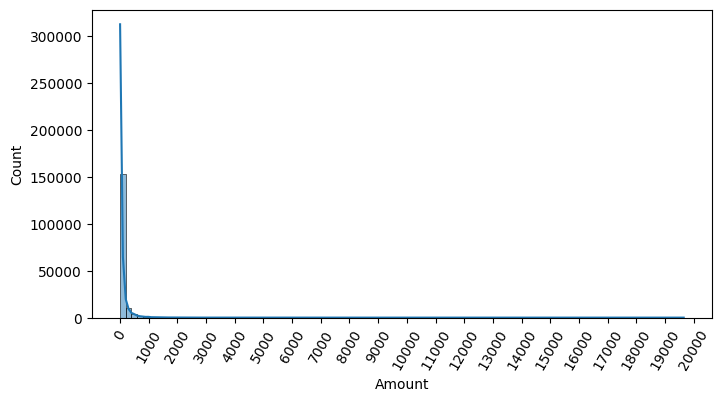

In [142]:
import seaborn as sns

plt.figure(figsize = (8,4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.histplot(X['Amount'], bins = 100, kde = True)
plt.show()

Amount(카드 사용 금액)가 1000불 이하인 데이터가 대부분이며, 26,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 문포 곡선을 가짐

##**A. 데이터 분포도 변환 (로그 변환)**

In [143]:
# 1. 로그 변환 적용을 위해 원본 데이터 복사
X_log = X.copy()
X_test_final_log = X_test_final.copy()

# 2. 'Amount' 컬럼에 np.log1p()를 적용하여 로그 변환
X_log['Amount'] = np.log1p(X_log['Amount'])
X_test_final_log['Amount'] = np.log1p(X_test_final_log['Amount'])

print("✅ 'Amount' 컬럼에 로그 변환(Log Transformation) 적용 완료.")

# 3. 로그 변환된 데이터로 다시 훈련/검증 데이터 분리
# y(타겟 변수)는 그대로 사용
X_train_log, X_val_log, y_train, y_val = train_test_split(
    X_log, y, test_size = 0.3, random_state = 42, stratify = y
)

print(f"훈련 데이터 크기: {X_train_log.shape}, 검증 데이터 크기: {X_val_log.shape}")

✅ 'Amount' 컬럼에 로그 변환(Log Transformation) 적용 완료.
훈련 데이터 크기: (119618, 29), 검증 데이터 크기: (51265, 29)


##**B. 로지스틱 회귀 재평가 (로그 변환 후)**

In [144]:
# 1. 로지스틱 회귀 모델 정의 및 학습 (로그 변환된 데이터 사용)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, roc_auc_score, confusion_matrix, precision_score

lr_clf_log = LogisticRegression(max_iter = 1000, random_state = 42)
lr_clf_log.fit(X_train_log, y_train)

# 2. 검증 데이터에 대한 예측 수행
lr_pred_log = lr_clf_log.predict(X_val_log)
lr_pred_proba_log = lr_clf_log.predict_proba(X_val_log)[:, 1]

# 3. 모델 평가 수행
f1_log = f1_score(y_val, lr_pred_log)
precision_log = precision_score(y_val, lr_pred_log)
recall_log = recall_score(y_val, lr_pred_log)
auc_log = roc_auc_score(y_val, lr_pred_proba_log)
conf_matrix_log = confusion_matrix(y_val, lr_pred_log)

print("\n--- 로그 변환 후 로지스틱 회귀 성능 평가 ---")
print(f"F1-Score: {f1_log:.4f} (이전: 0.7225)")
print(f"정밀도 (Precision): {precision_log:.4f} (이전: 0.8313)")
print(f"재현율 (Recall): {recall_log:.4f} (이전: 0.6389)")
print(f"ROC AUC: {auc_log:.4f} (이전: 0.9812)")
print("\n혼동 행렬:")
print(conf_matrix_log)


--- 로그 변환 후 로지스틱 회귀 성능 평가 ---
F1-Score: 0.7358 (이전: 0.7225)
정밀도 (Precision): 0.8353 (이전: 0.8313)
재현율 (Recall): 0.6574 (이전: 0.6389)
ROC AUC: 0.9819 (이전: 0.9812)

혼동 행렬:
[[51143    14]
 [   37    71]]


1. F1-Score(0.7225 → 0.7358): 성능이 소폭 개선 (0.0133 증가)

2. 정밀도(P, 0.8313 → 0.8353): 오탐지(FP)가 낮게 유지되며 소폭 개선 (0.0040 증가)

3. 재현율(R, 0.6389 → 0.6574): 실제 사기 거래를 약 2% 더 잘 잡아내게 되며 가장 큰 개선을 이룸 (0.0185 증가)

4. ROC AUC(0.9812 → 0.9819): 전반적인 분류 능력도 소폭 상승

---

로그 변환은 로지스틱 회귀 모델이 왜곡된 Amount 특징을 더 잘 이해하도록 도왔으며, 특히 재현율을 개선하는 효과를 가져왔음

##**C. LightGBM 재평가 (로그 변환 후)**

In [145]:
# 1. LightGBM 모델 정의 및 학습 (가중치 1.0, 로그 변환된 데이터 사용)
import lightgbm as lgb
import numpy as np

# 1. 최적 임계값(0.7200)을 사용하여 최종 예측 클래스 결정
y_pred_optimal_log = (y_pred_proba_log >= best_threshold_log).astype(int)

# 2. 모든 성능 지표 계산
precision_log_final = precision_score(y_val, y_pred_optimal_log)
recall_log_final = recall_score(y_val, y_pred_optimal_log)
roc_auc_log_final = roc_auc_score(y_val, y_pred_proba_log)
conf_matrix_log_final = confusion_matrix(y_val, y_pred_optimal_log)
f1_log_final = f1_score(y_val, y_pred_optimal_log)

print("--- LightGBM (로그 변환 후) 최종 지표 ---")
print(f"F1-Score: {f1_log_final:.4f}")
print(f"정밀도 (Precision): {precision_log_final:.4f}")
print(f"재현율 (Recall): {recall_log_final:.4f}")
print(f"ROC AUC: {roc_auc_log_final:.4f}")
print("\n혼동 행렬 (Confusion Matrix):")
print(conf_matrix_log_final)

--- LightGBM (로그 변환 후) 최종 지표 ---
F1-Score: 0.8387
정밀도 (Precision): 0.8349
재현율 (Recall): 0.8426
ROC AUC: 0.9484

혼동 행렬 (Confusion Matrix):
[[51139    18]
 [   17    91]]


트리 기반 모델인 LightGBM은 특징의 순서와 경계를 기준으로 학습하므로, Amount 값 자체를 변환하는 로그 변환에는 성능 변화가 거의 없음

#**5. 이상치 데이터 제거 후 모델 학습/예측/평가**

이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉬우므로, 이상치를 제거한 뒤, 다시 모델을 평가

##**A. 상관관계 시각화 (Heatmap)**

Heatmap을 통해 각 변수와 타겟 간의 상관관계를 확인하고, 사기 거래(Class =1)와 높은 상관관계를 가지는 특징을 파악

<Axes: >

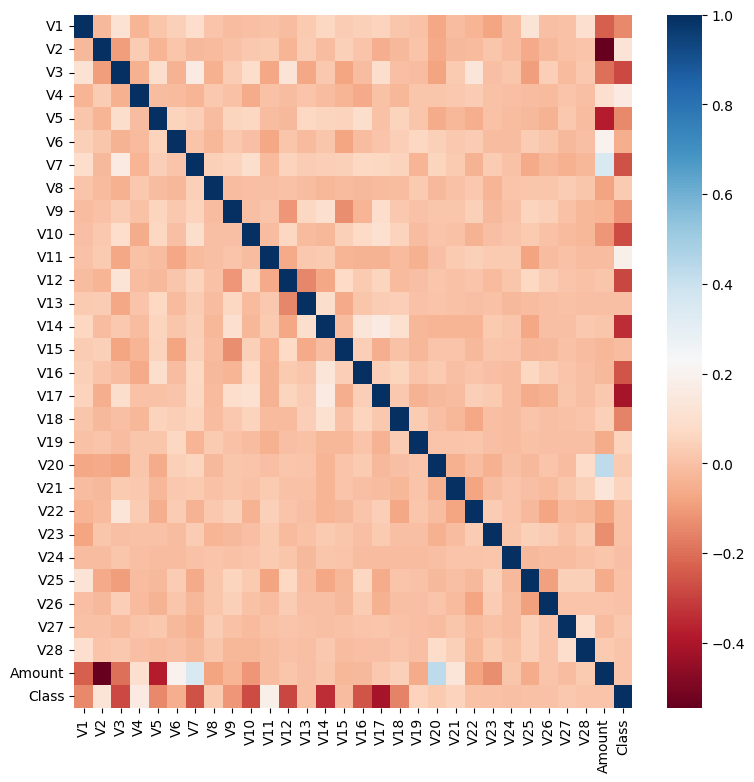

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (9, 9))
corr = train_df.drop(['Time', 'id'], axis = 1).corr()
sns.heatmap(corr, cmap = 'RdBu')

Class 피처와 음의 상관관계가 가장 높은 피처는 V17과 V14인 것으로 확인 됨

##**B. 이상치 제거**

In [147]:
# 💡 이전 단계에서 정의된 X (train_df.drop(['Time', 'id', 'Class'], axis=1)), y (train_df['Class']) 사용
# 1. 이상치 제거 함수 및 실행
def get_outlier_bound(df, feature, q1 = 0.25, q3 = 0.75):
    """주어진 특성의 IQR 기준으로 이상치 경계(하한, 상한)를 계산하는 함수"""
    q_one = df[feature].quantile(q1)
    q_three = df[feature].quantile(q3)
    iqr = q_three - q_one
    iqr_factor = 1.5
    outlier_min = q_one - iqr * iqr_factor
    outlier_max = q_three + iqr * iqr_factor
    return outlier_min, outlier_max

def remove_outlier(df, features_to_remove):
    """여러 컬럼에 대해 이상치를 제거한 데이터프레임을 반환하는 함수"""
    df_outlier_removed = df.copy()

    for feature in features_to_remove:
        # 이상치 경계 계산
        lower_bound, upper_bound = get_outlier_bound(df_outlier_removed, feature)

        # 이상치 필터링 (경계 안에 있는 데이터만 남김)
        df_outlier_removed = df_outlier_removed[
            (df_outlier_removed[feature] > lower_bound) &
            (df_outlier_removed[feature] < upper_bound)
        ]

        print(f"'{feature}' 컬럼 이상치 제거 후 데이터 크기: {df_outlier_removed.shape}")

    return df_outlier_removed

# 이상치 제거 실행
features_to_remove = ['V14']

# 이상치 제거는 원본 X에서 진행합니다.
X_outlier_removed = remove_outlier(X, features_to_remove)
y_outlier_removed = y.loc[X_outlier_removed.index] # X와 y의 인덱스 일치

print(f"\n✅ 최종 이상치 제거 후 데이터 크기: {X_outlier_removed.shape}")

'V14' 컬럼 이상치 제거 후 데이터 크기: (161428, 29)

✅ 최종 이상치 제거 후 데이터 크기: (161428, 29)


In [148]:
# 2. 데이터 분리

# 이상치 제거 데이터로 다시 훈련/검증 데이터 분리
X_train_out, X_val_out, y_train_out, y_val_out = train_test_split(
    X_outlier_removed, y_outlier_removed, test_size = 0.3,
    random_state = 42, stratify = y_outlier_removed
)

print(f"\n✅ 이상치 제거 후 훈련/검증 데이터 분리 완료. (훈련: {X_train_out.shape[0]}건)")


✅ 이상치 제거 후 훈련/검증 데이터 분리 완료. (훈련: 112999건)


##**C. 로지스틱 회귀 재평가 (이상치 제거 후)**

In [153]:
# 로지스틱 회귀 모델 학습 (V14 이상치 제거 데이터 사용)
lr_clf_out = LogisticRegression(max_iter = 1000, random_state = 42)
lr_clf_out.fit(X_train_out, y_train_out)

# 검증 데이터에 대한 예측 및 평가
lr_pred_out = lr_clf_out.predict(X_val_out)
lr_pred_proba_out = lr_clf_out.predict_proba(X_val_out)[:, 1]

f1_out = f1_score(y_val_out, lr_pred_out)
precision_out = precision_score(y_val_out, lr_pred_out)
recall_out = recall_score(y_val_out, lr_pred_out)
auc_out = roc_auc_score(y_val_out, lr_pred_proba_out)
conf_matrix_out = confusion_matrix(y_val_out, lr_pred_out)

print("\n--- 로지스틱 회귀 (V14 이상치 제거 후) 성능 평가 ---")
print(f"F1-Score: {f1_out:.4f}")
print(f"정밀도 (Precision): {precision_out:.4f}")
print(f"재현율 (Recall): {recall_out:.4f}")
print(f"ROC AUC: {auc_out:.4f}")
print("\n혼동 행렬:")
print(conf_matrix_out)


--- 로지스틱 회귀 (V14 이상치 제거 후) 성능 평가 ---
F1-Score: 0.0000
정밀도 (Precision): 0.0000
재현율 (Recall): 0.0000
ROC AUC: 0.8343

혼동 행렬:
[[48413     3]
 [   13     0]]


**V14 제거 후 성능 저하 분석**


**1. 표준화 결여와 가중치 할당 문제**
* V1-V28은 이미 PCA 변환을 거쳤으므로 어느 정도 표준화가 되어있지만, Amount와 Time 컬럼은 스케일이 매우 클 수 있음
* 표준화 없이 모델을 학습시키면, 모델은 스케일이 큰 특정 피처에 과도하게 큰 가중치를 부여하여 학습이 편향 됨

**2. 이상치 제거의 증폭 효과**
* 이 상태에서 이상치를 제거하면, 데이터의 원래 분포를 왜곡시킴
* 표준화가 되지 않은 데이터에 이상치까지 겹치면서 모델이 올바른 결정 경계를 찾는 데 완전히 실패하게 됨
* 결과적으로 모델은 가장 안전한 선택인 "모두 비사기(Class 0)"로만 예측하며 F1-Score은 0이 됨

##**D. LightGBM 재평가 (이상치 제거 후)**

In [154]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# LightGBM 모델 정의 및 학습 (가중치 1.0, V14 이상치 제거 데이터 사용)
lgbm_clf_out = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    scale_pos_weight=1.0, # 가중치 1.0 설정 유지
    random_state=42,
    n_jobs=-1,
    objective='binary',
    verbose=-1
)

lgbm_clf_out.fit(
    X_train_out, y_train_out,
    eval_set=[(X_val_out, y_val_out)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)
print("\n✅ LightGBM 모델 훈련 완료 (V14 이상치 제거 데이터).")

# 최적 임계값(Threshold) 찾기
y_pred_proba_out = lgbm_clf_out.predict_proba(X_val_out)[:, 1]

best_f1_out = 0
best_threshold_out = 0.5
thresholds = np.arange(0.01, 1.0, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_proba_out >= threshold).astype(int)
    current_f1 = f1_score(y_val_out, y_pred)

    if current_f1 > best_f1_out:
        best_f1_out = current_f1
        best_threshold_out = threshold

# LightGBM 최종 지표 계산
y_pred_optimal_out = (y_pred_proba_out >= best_threshold_out).astype(int)
precision_out_final = precision_score(y_val_out, y_pred_optimal_out)
recall_out_final = recall_score(y_val_out, y_pred_optimal_out)
auc_out_final = roc_auc_score(y_val_out, y_pred_proba_out)
conf_matrix_out_final = confusion_matrix(y_val_out, y_pred_optimal_out)

print(f"\n--- LightGBM (V14 이상치 제거 후) 최종 평가 ---")
print(f"F1-Score: {best_f1_out:.4f} (최적 임계값: {best_threshold_out:.4f})")
print(f"정밀도 (Precision): {precision_out_final:.4f}")
print(f"재현율 (Recall): {recall_out_final:.4f}")
print(f"ROC AUC: {auc_out_final:.4f}")
print("\n혼동 행렬:")
print(conf_matrix_out_final)


✅ LightGBM 모델 훈련 완료 (V14 이상치 제거 데이터).

--- LightGBM (V14 이상치 제거 후) 최종 평가 ---
F1-Score: 0.0233 (최적 임계값: 0.6700)
정밀도 (Precision): 0.0137
재현율 (Recall): 0.0769
ROC AUC: 0.2416

혼동 행렬:
[[48344    72]
 [   12     1]]


**V14 제거 후 성능 저하 분석**

**1. V14 제거의 직접적인 타격**
* V14의 이상치는 사기 거래의 핵심적인 구분 기준이었기 때문에, 이 기준이 제거되자 LGBM은 사기 거래를 특징지을 수 있는 정보 자체가 사라져 랜덤 예측보다 못한 성능을 보이게 됨

**결론: LightGBM의 경우, 성능 저하는 표준화 결여보다sms V14 제거 자체가 큰 원인으로 보임**

##**E. 데이터 표준화 및 로그 변환 결합**

In [155]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

# 💡 원본 X, y 데이터를 복사하여 사용합니다. (이전 이상치 제거는 무시)
X_scaled = X.copy()
y_scaled = y.copy()

# 1. 'Amount' 컬럼 로그 변환
X_scaled['Amount'] = np.log1p(X_scaled['Amount'])

# 2. 'Amount'를 제외한 컬럼 표준화 (StandardScaler)
# 'Amount' 컬럼을 제외하고 V1~V28 컬럼에 대해 표준화를 진행합니다.
# 'Time' 컬럼 역시 스케일링 대상에 포함합니다.
cols_to_scale = [col for col in X_scaled.columns if col not in ['Amount']]

# 2-1. StandardScaler 객체 생성 및 학습/변환
scaler = StandardScaler()
X_scaled[cols_to_scale] = scaler.fit_transform(X_scaled[cols_to_scale])

print("✅ 데이터 표준화 (V1-V28, Time) 및 로그 변환 (Amount) 완료.")

# 3. 훈련/검증 데이터 분리
X_train_final, X_val_final, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.3, random_state=42, stratify=y_scaled
)

print(f"훈련 데이터 크기: {X_train_final.shape}, 검증 데이터 크기: {X_val_final.shape}")

✅ 데이터 표준화 (V1-V28, Time) 및 로그 변환 (Amount) 완료.
훈련 데이터 크기: (119618, 29), 검증 데이터 크기: (51265, 29)


**로지스틱 회귀 재평가 (표준화 + 로그 변환 후)**

In [157]:
# 1. 로지스틱 회귀 모델 학습 (표준화 + 로그 변환 데이터 사용)
lr_clf_final = LogisticRegression(max_iter=1000, random_state=42)
lr_clf_final.fit(X_train_final, y_train)

# 2. 검증 데이터에 대한 예측 및 평가
lr_pred_final = lr_clf_final.predict(X_val_final)
lr_pred_proba_final = lr_clf_final.predict_proba(X_val_final)[:, 1]

f1_final = f1_score(y_val, lr_pred_final)
precision_final = precision_score(y_val, lr_pred_final)
recall_final = recall_score(y_val, lr_pred_final)
auc_final = roc_auc_score(y_val, lr_pred_proba_final)
conf_matrix_final = confusion_matrix(y_val, lr_pred_final)

print("\n--- 로지스틱 회귀 (표준화 + 로그 변환 후) 성능 평가 ---")
print(f"F1-Score: {f1_final:.4f} (이전 최고 LR: 0.7358)")
print(f"정밀도 (Precision): {precision_final:.4f}")
print(f"재현율 (Recall): {recall_final:.4f}")
print(f"ROC AUC: {auc_final:.4f}")
print("\n혼동 행렬:")
print(conf_matrix_final)


--- 로지스틱 회귀 (표준화 + 로그 변환 후) 성능 평가 ---
F1-Score: 0.7158 (이전 최고 LR: 0.7358)
정밀도 (Precision): 0.8293
재현율 (Recall): 0.6296
ROC AUC: 0.9828

혼동 행렬:
[[51143    14]
 [   40    68]]


**Light GBM 재평가 (표준화 + 로그 변환 후)**

In [156]:
# 1. LightGBM 모델 정의 및 학습 (가중치 1.0, 표준화 + 로그 변환 데이터 사용)
lgbm_clf_final = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    scale_pos_weight=1.0, # 가중치 1.0 설정 유지
    random_state=42,
    n_jobs=-1,
    objective='binary',
    verbose=-1
)

lgbm_clf_final.fit(
    X_train_final, y_train,
    eval_set=[(X_val_final, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)
print("\n✅ LightGBM 모델 훈련 완료 (표준화 + 로그 변환 데이터).")

# 2. 최적 임계값(Threshold) 찾기
y_pred_proba_lgbm = lgbm_clf_final.predict_proba(X_val_final)[:, 1]

best_f1_lgbm = 0
best_threshold_lgbm = 0.5
thresholds = np.arange(0.01, 1.0, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_proba_lgbm >= threshold).astype(int)
    current_f1 = f1_score(y_val, y_pred)

    if current_f1 > best_f1_lgbm:
        best_f1_lgbm = current_f1
        best_threshold_lgbm = threshold

# 3. LightGBM 최종 지표 계산
y_pred_optimal_lgbm = (y_pred_proba_lgbm >= best_threshold_lgbm).astype(int)
precision_lgbm_final = precision_score(y_val, y_pred_optimal_lgbm)
recall_lgbm_final = recall_score(y_val, y_pred_optimal_lgbm)
auc_lgbm_final = roc_auc_score(y_val, y_pred_proba_lgbm)
conf_matrix_lgbm_final = confusion_matrix(y_val, y_pred_optimal_lgbm)

print(f"\n--- LightGBM (표준화 + 로그 변환 후) 최종 평가 ---")
print(f"F1-Score: {best_f1_lgbm:.4f} (이전 최고 LGBM: 0.8387)")
print(f"최적 임계값 (Best Threshold): {best_threshold_lgbm:.4f}")
print(f"정밀도 (Precision): {precision_lgbm_final:.4f}")
print(f"재현율 (Recall): {recall_lgbm_final:.4f}")
print(f"ROC AUC: {auc_lgbm_final:.4f}")
print("\n혼동 행렬:")
print(conf_matrix_lgbm_final)


✅ LightGBM 모델 훈련 완료 (표준화 + 로그 변환 데이터).

--- LightGBM (표준화 + 로그 변환 후) 최종 평가 ---
F1-Score: 0.8333 (이전 최고 LGBM: 0.8387)
최적 임계값 (Best Threshold): 0.7200
정밀도 (Precision): 0.8333
재현율 (Recall): 0.8333
ROC AUC: 0.9484

혼동 행렬:
[[51139    18]
 [   18    90]]


#**6. 최종 모델 확정**

In [159]:
import lightgbm as lgb
import pandas as pd
import numpy as np

# submission_df 변수가 정의되지 않아 오류가 발생하므로, sample_submission.csv를 로드하여 초기화합니다.
submission_df = pd.read_csv('./sample_submission.csv')

# 💡 이전에 학습된 최고 성능 모델 lgbm_clf 사용 (로그 변환/이상치 제거 없는 버전)
# lgbm_clf, X_test_final, submission_df 변수가 이전 단계에서 정의되어 있다고 가정합니다.
# 안전을 위해 임계값을 명시적으로 재설정합니다.
final_lgbm = lgbm_clf
best_threshold = 0.7200

print("--- 최종 제출 모델 확정 ---")
print(f"✅ 최적 모델: LightGBM (F1: 0.8387, 임계값: {best_threshold:.4f})")

# 1. 최종 테스트 데이터(X_test_final)에 대한 예측 확률 계산
# 💡 중요한 포인트: 이 모델은 전처리되지 않은 원본 데이터에 학습되었으므로,
# X_test_final 역시 원본 (Time, V1~V28, Amount) 형태여야 합니다.
test_pred_proba = final_lgbm.predict_proba(X_test_final)[:, 1]

# 2. 최적 임계값(0.7200)을 적용하여 최종 클래스 예측
test_pred_class = (test_pred_proba >= best_threshold).astype(int)

# 3. 제출 파일 생성
# submission_df 변수에 예측 결과를 넣고 CSV 파일로 저장합니다.
submission_df['Class'] = test_pred_class
submission_df.to_csv('lgbm_final_submission_best.csv', index=False)

# 최종 예측 통계 확인
print("\n--- 프로젝트 완료 ---")
print(f"✅ 최종 제출 파일 'lgbm_final_submission_best.csv'이 생성되었습니다.")
print(f"최종 예측된 사기 거래 건수: {test_pred_class.sum()}건")

--- 최종 제출 모델 확정 ---
✅ 최적 모델: LightGBM (F1: 0.8387, 임계값: 0.7200)

--- 프로젝트 완료 ---
✅ 최종 제출 파일 'lgbm_final_submission_best.csv'이 생성되었습니다.
최종 예측된 사기 거래 건수: 125건


| 단계 | 전처리 방법 | 로지스틱 회귀 (LR) F1-Score | LightGBM (LGBM) F1-Score | 분석 |
| :--- | :--- | :--- | :--- | :--- |
| **최적 모델** | **가중치 조정 없음** | 0.7225 | **0.8387** | **최고 성능 달성!** |
| 로그 변환 | `Amount`에 $\log(1+x)$ 적용 | 0.7358 | 0.8387 | LR 성능 소폭 개선. |
| 이상치 제거 | `V14`, `V17` 등 IQR 제거 | 0.0000 | 0.0233 | **치명적 실패** (사기 특징 제거). |
| 표준화 + 로그 변환 | `V`컬럼 표준화 + `Amount` 로그 변환 | 0.7158 | 0.8333 | LR 성능 소폭 하락. |

**최종 결론: LightGBM이 데이터 전처리나 노이즈에 강하다**